### Orchestrator worker workflow

In [1]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

from typing import Annotated, TypedDict, Literal
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import operator

load_dotenv()

/Users/srinivas/Documents/Others/My_projects/Python/DSAIML/agenticai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
model = init_chat_model(
    model="llama-3.1-8b-instant",  # or any other Groq model
    model_provider="groq",
    temperature=0.7,
)

In [3]:
# structured output for each section
class SectionSchema(BaseModel):
    title: str = Field(description="Title of the section for the report")
    overview: str = Field(description="A brief one-line overview of the content required this section for the report")

# structured output for all sections (required for the report)
class AllSectionsSchema(BaseModel):
    sections: list[SectionSchema] = Field(description="All the sections required for the report")

# update the model with the structured output schema
planner_model = model.with_structured_output(AllSectionsSchema)

#### Creating workers dynamically in LangGraph

Because orchestrator-worker workflows are common, LangGraph has `Send API` to support this. It lets you dynamically create worker nodes and send each specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node.

In [4]:
# lets build a state

class ReportState(TypedDict):
    topic: str
    sections: list[SectionSchema] # list of sections
    completed_sections: Annotated[list, operator.add] # all the workers will write to this list parallelly
    final_report: str

class WorkerState(TypedDict):
    section: SectionSchema
    completed_sections: Annotated[list, operator.add]

In [13]:
# Node implementation

def orchestrator_node(state: ReportState) -> ReportState:
    """Orchestrator generates a plan for the report"""

    messages = [
        SystemMessage("You are a helpful assistant that generates a plan for a report"),
        HumanMessage(f"Topic for the report: {state['topic']}"),
    ]

    report_sections_plan = planner_model.invoke(messages)

    print("Plan for the report: ", report_sections_plan)
   
    return {"sections": report_sections_plan.sections}

def worker_node(state: WorkerState) -> WorkerState:
    """Worker generates a report section"""

    messages = [
        SystemMessage("You are a helpful assistant that generates a report section"),
        HumanMessage(f"""Information about the section: \n\n Section Title: {state['section'].title}  
        \n\n Section Description: {state['section'].overview}"""),
    ]

    report_section = model.invoke(messages)

    print("Report section: ", report_section)

    return {"completed_sections": [report_section.content]}

def assign_worker(state: ReportState) -> list[Send]:
    """Assigns a worker to a section"""

    return [Send("worker", {"section": each_section}) for each_section in state["sections"]]

def syntherizer_node(state: ReportState) -> ReportState:
    """Syntherizes the report"""

    completed_sections = state["completed_sections"]

    final_report = "\n\n----\n\n".join(completed_sections)

    return {"final_report": final_report}

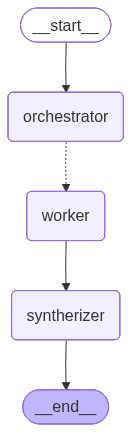

In [14]:
# Set up the state graph
graph = StateGraph(ReportState)

# Add the nodes
graph.add_node("orchestrator", orchestrator_node)
graph.add_node("worker", worker_node)
graph.add_node("syntherizer", syntherizer_node)

# Add the edges
graph.add_edge(START, "orchestrator")
graph.add_conditional_edges("orchestrator", assign_worker, ["worker"])
graph.add_edge("worker", "syntherizer")
graph.add_edge("syntherizer", END)

# Compile the graph
workflow = graph.compile()
workflow

In [15]:
initial_state = {
    "topic": "AI in Healthcare"
}

response = workflow.invoke(initial_state)

from IPython.display import Markdown

Markdown(response["final_report"])

Plan for the report:  sections=[SectionSchema(title='Introduction to AI in Healthcare', overview='Current state of AI in healthcare, its applications, and challenges'), SectionSchema(title='Applications of AI in Healthcare', overview='Discussion on the various applications of AI in healthcare, including diagnosis, treatment, and patient engagement')]
Report section:  content='**Applications of AI in Healthcare**\n\n**Introduction**\n\nThe integration of Artificial Intelligence (AI) in healthcare has revolutionized the way medical professionals diagnose, treat, and engage with patients. AI has the potential to improve patient outcomes, reduce healthcare costs, and enhance the overall quality of care. This section discusses the various applications of AI in healthcare, including diagnosis, treatment, and patient engagement.\n\n**Applications of AI in Healthcare**\n\n### Diagnosis\n\n1. **Medical Imaging Analysis**: AI-powered algorithms can analyze medical images such as X-rays, CT scans

**Introduction to AI in Healthcare**

**Overview**

Artificial Intelligence (AI) has revolutionized the healthcare industry by transforming the way medical professionals diagnose, treat, and manage patient care. The integration of AI in healthcare has led to improved accuracy, efficiency, and patient outcomes. However, there are still many challenges to be addressed, and this section aims to provide an overview of the current state of AI in healthcare, its applications, and the challenges that need to be overcome.

**Current State of AI in Healthcare**

The adoption of AI in healthcare has been rapid, with many healthcare organizations leveraging AI technologies to improve patient care. Some of the key areas where AI is being applied include:

* **Diagnostic imaging**: AI-powered algorithms are being used to analyze medical images such as X-rays, CT scans, and MRI scans to detect diseases such as cancer, cardiovascular disease, and neurological disorders.
* **Clinical decision support**: AI-powered systems are being used to analyze patient data and provide healthcare professionals with decision support tools to aid in diagnosis and treatment.
* **Predictive analytics**: AI-powered systems are being used to analyze large datasets to identify high-risk patients and predict patient outcomes.

**Applications of AI in Healthcare**

AI has numerous applications in healthcare, including:

* **Robot-assisted surgery**: AI-powered robots are being used to assist surgeons during operations, improving precision and reducing recovery time.
* **Personalized medicine**: AI-powered systems are being used to analyze patient data and tailor treatment plans to individual patients.
* **Telemedicine**: AI-powered systems are being used to facilitate remote patient monitoring and diagnosis.

**Challenges in AI in Healthcare**

Despite the many benefits of AI in healthcare, there are still several challenges that need to be addressed, including:

* **Data quality and availability**: The quality and availability of data are critical to the success of AI in healthcare. However, many healthcare organizations face challenges in collecting and maintaining high-quality data.
* **Regulatory frameworks**: The regulatory frameworks for AI in healthcare are still evolving and need to be clarified to ensure that AI systems are safe and effective.
* **Bias and fairness**: AI systems can perpetuate bias and unfairness, particularly if they are trained on biased data. This can have serious consequences in healthcare, where decisions can have a significant impact on patient outcomes.

**Future Directions**

As AI continues to evolve, it is likely to have a profound impact on the healthcare industry. Some of the future directions for AI in healthcare include:

* **Increased adoption**: AI is expected to become increasingly widespread in healthcare, with more organizations adopting AI technologies.
* **Improved data quality**: Efforts to improve data quality and availability will be critical to the success of AI in healthcare.
* **Greater focus on ethics and bias**: There will need to be a greater focus on ensuring that AI systems are fair, unbiased, and transparent.

By understanding the current state of AI in healthcare, its applications, and challenges, we can better navigate the future of this rapidly evolving field.

----

**Applications of AI in Healthcare**

**Introduction**

The integration of Artificial Intelligence (AI) in healthcare has revolutionized the way medical professionals diagnose, treat, and engage with patients. AI has the potential to improve patient outcomes, reduce healthcare costs, and enhance the overall quality of care. This section discusses the various applications of AI in healthcare, including diagnosis, treatment, and patient engagement.

**Applications of AI in Healthcare**

### Diagnosis

1. **Medical Imaging Analysis**: AI-powered algorithms can analyze medical images such as X-rays, CT scans, and MRIs to detect abnormalities and diagnose conditions more accurately.
2. **Disease Prediction**: AI can analyze patient data and medical history to predict the likelihood of developing certain diseases, enabling early intervention and prevention.
3. **Clinical Decision Support Systems**: AI-powered systems can provide healthcare professionals with real-time clinical decision support, improving diagnosis accuracy and reducing errors.

### Treatment

1. **Personalized Medicine**: AI can analyze patient data and medical history to develop personalized treatment plans, improving treatment outcomes and reducing side effects.
2. **Robot-Assisted Surgery**: AI-powered robots can assist surgeons during operations, improving accuracy and reducing recovery time.
3. **Precision Medicine**: AI can help identify the most effective treatment options for patients based on their genetic profiles and medical history.

### Patient Engagement

1. **Virtual Assistants**: AI-powered virtual assistants can help patients manage their health, answer medical questions, and provide personalized health advice.
2. **Patient Engagement Platforms**: AI-powered platforms can engage patients in their care, providing them with personalized health information, medication reminders, and appointment scheduling.
3. **Chatbots**: AI-powered chatbots can provide patients with 24/7 access to medical information and support, improving patient satisfaction and outcomes.

**Benefits of AI in Healthcare**

1. **Improved Patient Outcomes**: AI can help healthcare professionals make more accurate diagnoses and develop personalized treatment plans, improving patient outcomes.
2. **Reduced Healthcare Costs**: AI can help reduce healthcare costs by minimizing errors, improving efficiency, and reducing unnecessary hospitalizations.
3. **Enhanced Patient Experience**: AI can help improve patient engagement, satisfaction, and experience, leading to better health outcomes and increased patient loyalty.

**Challenges and Limitations**

1. **Data Quality and Availability**: AI requires high-quality and relevant data to function effectively, which can be a challenge in healthcare where data is often incomplete or inaccurate.
2. **Regulatory Frameworks**: AI in healthcare is subject to various regulatory frameworks, which can be complex and time-consuming to navigate.
3. **Cybersecurity Risks**: AI in healthcare can be vulnerable to cyber threats, compromising patient data and confidentiality.

**Conclusion**

The applications of AI in healthcare are vast and promising, with the potential to improve patient outcomes, reduce healthcare costs, and enhance the overall quality of care. However, there are challenges and limitations that must be addressed, such as data quality and availability, regulatory frameworks, and cybersecurity risks.

## How `completed_sections` Gets Populated

The key is the special annotation used in the state definition:

```python
class ReportState(TypedDict):
    completed_sections: Annotated[list, operator.add]  # ← This is the magic!
```

### The `Annotated[list, operator.add]` Pattern

This annotation tells LangGraph:
1. **Multiple nodes can write to this field** 
2. **Use `operator.add` to combine the values** (list concatenation)

### The Flow:

1. **Orchestrator creates the plan** (generates sections)

2. **`assign_worker` spawns multiple workers in parallel:**
   ```python
   def assign_worker(state: ReportState) -> list[Send]:
       return [Send("worker", {"section": each_section}) for each_section in state["sections"]]
   ```
   This creates a separate `worker` node execution for each section.

3. **Each worker completes and returns its result:**
   ```python
   def worker_node(state: WorkerState) -> WorkerState:
       # ... generates report section ...
       return {"completed_sections": [report_section.content]}
   ```

4. **LangGraph automatically merges all worker outputs:**
   - Worker 1 returns: `{"completed_sections": ["Section 1 content"]}`
   - Worker 2 returns: `{"completed_sections": ["Section 2 content"]}`
   - Worker 3 returns: `{"completed_sections": ["Section 3 content"]}`
   
   LangGraph uses `operator.add` to combine them:
   ```python
   ["Section 1 content"] + ["Section 2 content"] + ["Section 3 content"]
   # Results in: ["Section 1 content", "Section 2 content", "Section 3 content"]
   ```

5. **The synthesizer receives the complete list:**
   ```python
   def syntherizer_node(state: ReportState) -> ReportState:
       completed_sections = state["completed_sections"]  # All sections from all workers!
       final_report = "\n\n----\n\n".join(completed_sections)
       return {"final_report": final_report}
   ```

### Why Both States Have It

```python
class ReportState(TypedDict):
    completed_sections: Annotated[list, operator.add]  # Collects from ALL workers

class WorkerState(TypedDict):
    completed_sections: Annotated[list, operator.add]  # Individual worker writes here
```

- **WorkerState**: Each individual worker writes to this
- **ReportState**: LangGraph automatically aggregates all worker outputs into this shared state

This is the **orchestrator-worker pattern** in LangGraph - multiple workers execute in parallel, and their outputs are automatically merged into the parent state using the reducer function (`operator.add`).